# Face mask detection

Here I am going to detect whether a person is wearing mask or not. I am focussing on only two classes that are 'face_with_mask' and face_no_mask'.

#                  The Second Project is "Real Time Face Mask Detection"

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.1 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from mtcnn.mtcnn import MTCNN

# Loading datasets

In [4]:
images=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/train.csv"))
submission=pd.read_csv(os.path.join("/kaggle/input/face-mask-detection-dataset/submission.csv"))

In [5]:
print(len(train))
train.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [6]:
print(len(submission))
submission.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


In [7]:
len(os.listdir(images))

6024

## We are having 6024 images.

In [8]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()

In [9]:
print(len(b),len(a))

4326 6024


In [10]:
train_images=a[1698:]
test_images=a[:1698]

In [19]:
test_images[90]

'0100.jpg'

Let's see some of the images.

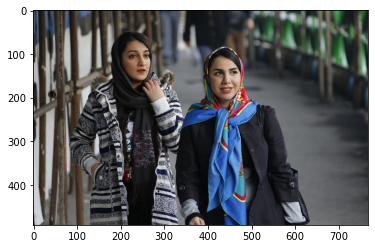

In [20]:
img=plt.imread(os.path.join(images,test_images[9]))
plt.imshow(img)
plt.show()

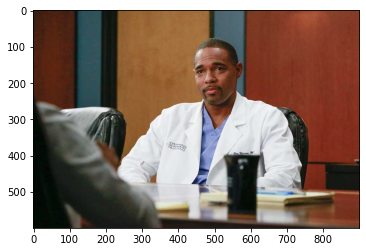

In [21]:
img=plt.imread(os.path.join(images,train_images[10]))
plt.imshow(img)
plt.show()

In [22]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[[581, 198, 693, 317], [363, 189, 478, 343], [773, 228, 863, 338]]


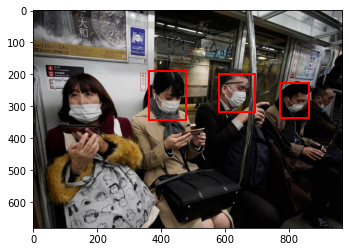

In [25]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox  
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[9]))
image=train_images[9]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

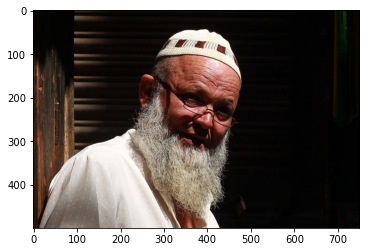

In [26]:
image=train_images[50]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

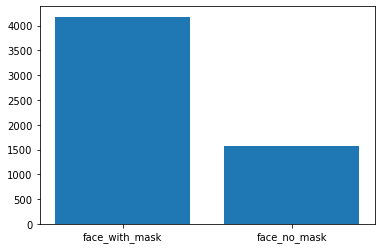

In [27]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

# Creating training data

In [29]:
img_size=50
data=[]
path='/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images'
def create_data():
       for i in range(len(train)):
            arr=[]
            for j in train.iloc[i]:
                   arr.append(j)
            img_array=cv2.imread(os.path.join(images,arr[0]),cv2.IMREAD_GRAYSCALE)
            crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            new_img_array=cv2.resize(crop_image,(img_size,img_size))
            data.append([new_img_array,arr[5]])
create_data()      

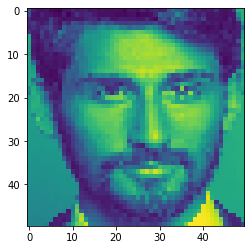

In [30]:
data[0][0]
plt.imshow(data[0][0])

In [31]:
x=[]
y=[]
for features, labels in data:
    x.append(features)
    y.append(labels)
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()
y=lbl.fit_transform(y)

In [32]:
x=np.array(x).reshape(-1,50,50,1)
x=tf.keras.utils.normalize(x,axis=1)
from keras.utils import to_categorical
y = to_categorical(y)

# Model Fitting

In [33]:
from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape=x.shape[1:],activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


In [34]:

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
model.fit(x,y,epochs=30,batch_size=5)

Epoch 1/30
5749/5749 [==============================] - 9s 2ms/step - loss: 0.5724 - accuracy: 0.7266
Epoch 2/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.4788 - accuracy: 0.7587
Epoch 3/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.4171 - accuracy: 0.8029
Epoch 4/30
5749/5749 [==============================] - 9s 1ms/step - loss: 0.3793 - accuracy: 0.8287
Epoch 5/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.3390 - accuracy: 0.8534
Epoch 6/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.3124 - accuracy: 0.8643
Epoch 7/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.2905 - accuracy: 0.8753
Epoch 8/30
5749/5749 [==============================] - 9s 2ms/step - loss: 0.2677 - accuracy: 0.8852
Epoch 9/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.2442 - accuracy: 0.8895
Epoch 10/30
5749/5749 [==============================] - 8s 1ms/step - loss: 0.221

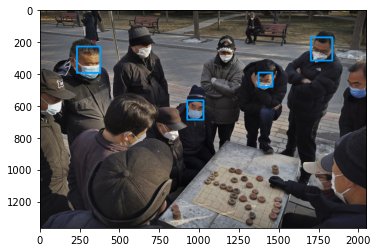

In [36]:
detector=MTCNN()
img=plt.imread(os.path.join(images,test_images[6]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)

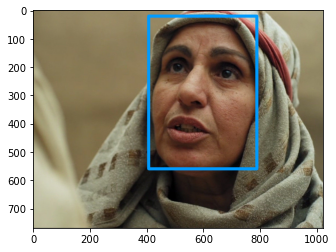

In [38]:
img=plt.imread(os.path.join(images,test_images[19]))
face=detector.detect_faces(img)
for face in face:
        bounding_box=face['box']
        x=cv2.rectangle(img,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              10)
        plt.imshow(x)